In [90]:
import os
import requests
from bs4 import BeautifulSoup
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnableLambda,RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,END,MessagesState
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [57]:
from dotenv import load_dotenv
load_dotenv()

True

In [58]:
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [59]:

class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [60]:
from langchain.output_parsers import PydanticOutputParser

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [61]:
def supervisor_funtion(state: MessagesState):
    question = state["messages"][0]
    print(f"Supervisor received question: {question}")

    template = """
    You are a categorization assistant.
    Classify the following user query into one of these categories:
    - "USA": If it relates to the GDP of the United States 
    - "Latest-News": If it is asking for very recent, current temperature or weather, trending, or breaking news.
    - "Not-Related": If it doesn't fit either of the above.
    Respond with ONLY the category name. Do not explain.
    User query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(
        input_variables=["question"],
        template=template,
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    chain = prompt | model | parser
    response = chain.invoke({"question": question})
    print(f"Supervisor response: {response}")

    # Return the classification in a structured way
    return {
        "messages": state["messages"] + [AIMessage(content=response.Topic)],
        "classification": response.Topic  # Explicitly store the classification
    }

In [62]:
def router(state: MessagesState):
    # Check if "classification" exists in state (from supervisor)
    if "classification" in state:
        classification = state["classification"]
    else:
        # Fallback: Extract from last message (backward compatibility)
        last_message = state["messages"][-1]
        classification = last_message.content if isinstance(last_message, AIMessage) else last_message
    
    print(f"[Router] Classification: {classification}")  # Debug log
    
    if classification == "Latest-News":
        return "Web Crawler Call"
    elif classification == "USA":
        return "RAG Call"
    else:
        return "LLM Call"

In [63]:
def llm(state:MessagesState):
    question=state["messages"][0]
    print(f"LLM received question: {question}")

    template = """You are a helpful assistant. Your task is to provide the information on the topic: {question} """

    response = model.invoke(template.format(question=question))
    print(f"LLM response: {response.content}")
    return {"messages":[response.content]}


In [64]:
embeddings=HuggingFaceEmbeddings(
    model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hello world"))

384

In [65]:
loader=DirectoryLoader("./data",glob="*.txt",loader_cls=TextLoader)
documents=loader.load()
text_splitter=RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=0)
docs=text_splitter.split_documents(documents)
vectorstore=Chroma.from_documents(docs,embeddings,collection_name="usa")



In [66]:
retriever=vectorstore.as_retriever(search_kwargs={"k":1})

In [97]:

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [98]:
def rag(state: MessagesState):
    print("-> RAG CALL ->")

    # Extract the content from the HumanMessage object
    if isinstance(state["messages"][0], HumanMessage):
        question = state["messages"][0].content
    else:
        question = state["messages"][0]
    
    prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        input_variables=['context', 'question']
    )

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()} 
        | prompt 
        | model 
        | StrOutputParser()
    )

    result = rag_chain.invoke(question)
    return {"messages": [result]}

In [99]:
def webCrawler(state: MessagesState):
    query = state["messages"][0]
    print(f"WebCrawler received query: {query}")

    # Use a news API (e.g., NewsAPI, GNews) or scrape a news site like BBC
    news_url = "https://news.google.com/search?q=new+delhi&hl=en-IN&gl=IN&ceid=IN:en"
    headers = {"User-Agent": "Mozilla/5.0"}
    
    try:
        response = requests.get(news_url, headers=headers)
        soup = BeautifulSoup(response.text, "html.parser")
        
        # Extract headlines (Google News structure)
        headlines = soup.select("h3")[:5]  # Top 5 headlines
        news_list = [f"📰 {h.get_text(strip=True)}" for h in headlines]
        
        answer = "Latest News in New Delhi:\n" + "\n".join(news_list)
    except Exception as e:
        answer = f"⚠️ Could not fetch live news. Error: {str(e)}"
    
    return {"messages": state["messages"] + [AIMessage(content=answer)]}

In [100]:
def validator(state: MessagesState):
    user_query = state["messages"][0]
    response = state["messages"][-1]

    validation_prompt = PromptTemplate(
    input_variables=["query", "answer"],
    template="""You are a strict evaluator. A user asked: "{query}"

    The assistant replied: "{answer}"

    For news queries, is this answer helpful (even if not exhaustive)?
    Respond with exactly one word: Yes or No."""
    )

    chain = validation_prompt | model | StrOutputParser()
    validation_result = chain.invoke({"query": user_query, "answer": response}).strip()

    print(f"[Validator] Validation result: {validation_result}")
    
    attempts = state.get("attempts", 0) + 1
    return {
        "messages": state["messages"] + [AIMessage(content=validation_result)],
        "validation_result": validation_result.lower(),
        "attempts": attempts
    }


In [101]:
def routerValidator(state: dict):
    if state.get("validation_result", "") == "yes":  
        return "End"
    elif state.get("attempts", 0) < 2:
        print("[RouterValidator] Retrying with LLM.")
        return "Supervisor"
    else:
        return "End"

In [102]:
workflow= StateGraph(MessagesState)

In [103]:
workflow.add_node(
    "supervisor",supervisor_funtion,)

In [104]:
workflow.add_node("LLM",llm)

In [105]:
workflow.add_node("RAG",rag)

In [106]:
workflow.add_node("webCrawler",webCrawler)

In [107]:
workflow.add_node("validator",validator)

In [108]:
workflow.set_entry_point("supervisor")

In [109]:
workflow.add_conditional_edges(
    "supervisor",
    router,{
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "Web Crawler Call": "webCrawler",
    }
)

In [110]:
workflow.add_conditional_edges(
    "validator",
    routerValidator,
    {
        "Supervisor": "supervisor",
        "End": END
    }
)



In [111]:
workflow.add_edge("LLM", "validator")
workflow.add_edge("RAG", "validator")
workflow.add_edge("webCrawler", "validator")

In [112]:
workflow.add_edge("validator",END)

In [113]:
app=workflow.compile()

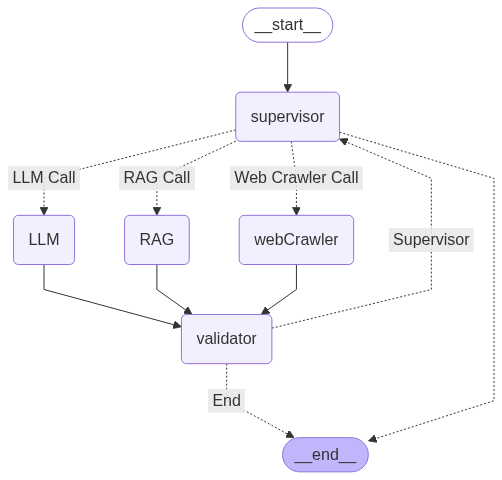

In [114]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [118]:
test_input = {"messages": [HumanMessage(content="Tell me about the war in Ukraine?")]}


In [ ]:
# Run the entire pipeline
final_output = app.invoke(test_input)

# View final response
from pprint import pprint
pprint(final_output["messages"][-1].content)


Supervisor received question: content='Tell me about the war in Ukraine?' additional_kwargs={} response_metadata={} id='cb2f51ef-3c53-4911-9895-c492aadcfa6b'
Supervisor response: Topic='Not-Related' Reasoning='The query asks about the war in Ukraine, which is a geopolitical event not directly related to US GDP or breaking news.'
[Router] Classification: Not-Related
LLM received question: content='Tell me about the war in Ukraine?' additional_kwargs={} response_metadata={} id='cb2f51ef-3c53-4911-9895-c492aadcfa6b'
LLM response: The war in Ukraine, which began with a full-scale Russian invasion on February 24, 2022, is a complex and ongoing conflict with deep historical roots.  It's impossible to fully summarize it in a short response, but here's a breakdown of key aspects:

**Background:**

* **Historical Context:**  Ukraine and Russia share deep historical and cultural ties, but Ukraine has also experienced periods of Russian domination and sought independence.  The collapse of the Sov

In [ ]:
test_input = {
    "messages": [HumanMessage(content="GDP of USA")]
}


In [117]:
# Run the entire pipeline
final_output = app.invoke(test_input)

# View final response
from pprint import pprint
pprint(final_output["messages"][-2].content)

Supervisor received question: content='GDP of USA' additional_kwargs={} response_metadata={} id='4b1a670f-da5f-495b-938e-d44649230702'
Supervisor response: Topic='USA' Reasoning="The query explicitly mentions 'GDP of USA', directly relating to the United States' GDP."
[Router] Classification: USA
-> RAG CALL ->
[Validator] Validation result: Yes
('The U.S. nominal GDP in 2024 is estimated at $28 trillion, representing '
 "about 25% of the global economy.  This makes it the world's largest economy "
 'by nominal GDP.  The U.S. also has a high GDP per capita, around $83,000.')


In [ ]:
test_input = {"messages": [HumanMessage(content="lastest news")]}
# Run the entire pipeline
final_output = app.invoke(test_input)
# View final response
from pprint import pprint
pprint(final_output["messages"][-2].content)

Supervisor received question: content='lastest news' additional_kwargs={} response_metadata={} id='934f4807-87b9-4d9c-8bcc-4907a7c28c12'
Supervisor response: Topic='Latest-News' Reasoning="The query explicitly asks for 'lastest news'."
[Router] Classification: Latest-News
WebCrawler received query: content='lastest news' additional_kwargs={} response_metadata={} id='934f4807-87b9-4d9c-8bcc-4907a7c28c12'
[Validator] Validation result: Yes
('Latest News in New Delhi:\n'
 '📰 India Meteorological Department predicts heavy rainfall in Delhi\n'
 '📰 Posts on X\n'
 '📰 Delhi schools receive bomb threats, police investigate\n'
 '📰 News about CM • New Delhi • Andhra Pradesh')
